<a href="https://colab.research.google.com/github/DunkleCat/ia-titanic/blob/master/titanic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerie

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# Rende i numeri a virgola mobile più leggibili
np.set_printoptions(precision=3, suppress=True)

# Dataframe

## Download del dataset

In [0]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)

train_dataframe = pd.read_csv(train_file_path)
test_dataframe = pd.read_csv(test_file_path)

dataframe = train_dataframe.append(test_dataframe, ignore_index=True)
dataframe = dataframe.replace('unknown', np.nan)
target_label = "survived"

## Vista generica del dataset

In [3]:
dataframe.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,NaN,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,NaN,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,NaN,Queenstown,y


## Ottimizzazione del dataset

La rete neurale lavora sfruttando i numeri e non le stringhe. Per questo motivo conviene trasformare ogni colonna che contiene degli identificatori scritti come carattere in numeri interi che rappresentino la classe corrispondente. 

In [0]:
for elem in dataframe:
  if type(dataframe[elem][1]) is str:
    dataframe[elem] = pd.Categorical(dataframe[elem])
    dataframe[elem] = getattr(dataframe, elem).cat.codes

## Dataset post-ottimizzazione

In [5]:
dataframe.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,1,22.0,1,0,7.2500,2,-1,2,0
1,1,0,38.0,1,0,71.2833,0,2,0,0
2,1,0,26.0,0,0,7.9250,2,-1,2,1
3,1,0,35.0,1,0,53.1000,0,2,2,0
4,0,1,28.0,0,0,8.4583,2,-1,1,1


# Albero di decisione


## Setup

In [6]:
import sklearn
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

train, test = train_test_split(dataframe, test_size=0.1)
print(len(train), 'train examples')
print(len(test), 'test examples')

model_rf = RandomForestClassifier(random_state=1)
model_dt = DecisionTreeClassifier(random_state=1)

801 train examples
90 test examples


## Addestramento

In [0]:
train_target = train.pop(target_label)
model_rf.fit(train, train_target)
model_dt.fit(train, train_target)

## Test

[Random Forest]: Accuratezza Fase di Test:  0.8333333333333334


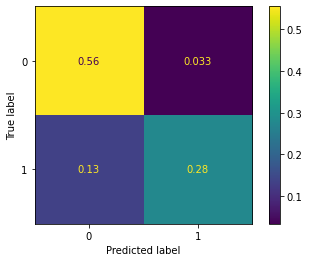

[Decision Tree]: Accuratezza Fase di Test:  0.7444444444444445


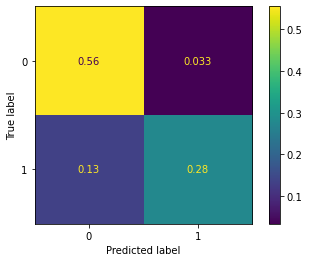

In [8]:
test_target = test.pop(target_label)

preds = model_rf.predict(test)
test_accuracy = metrics.accuracy_score(test_target, preds)
print('[Random Forest]: Test Accuracy {}'.format(test_loss, test_accuracy))
metrics.plot_confusion_matrix(model_rf, test, test_target, normalize='all')
plt.show()

preds = model_dt.predict(test)
test_accuracy = metrics.accuracy_score(test_target, preds)
print('[Decision Tree]: Test Accuracy {}'.format(test_loss, test_accuracy))
metrics.plot_confusion_matrix(model_rf, test, test_target, normalize='all')
plt.show()

# Rete neurale

## Setup


In [9]:
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataframe, test_size=0.1)
train, val = train_test_split(train, test_size=0.1)
print(len(train), 'train examples')
print(len(test), 'test examples')
print(len(val), 'val example')

720 train examples
90 test examples
81 val example


## Preparazione del modello

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

## Preparazione del Dataset

In [11]:
train, test = train_test_split(dataframe, test_size=0.1)
train, val = train_test_split(train, test_size=0.1)
print(len(train), 'train examples')
print(len(test), 'test examples')
print(len(val), 'val example')

720 train examples
90 test examples
81 val example


## Addestramento

In [0]:
# Creazione del dataset tensorflow di training
train_target = train.pop(target_label)
train_dataset = (tf.data.Dataset.from_tensor_slices((train.values, train_target.values))).shuffle(len(train)).batch(1)

# Fase di Training
history = model.fit(train_dataset, epochs=100)

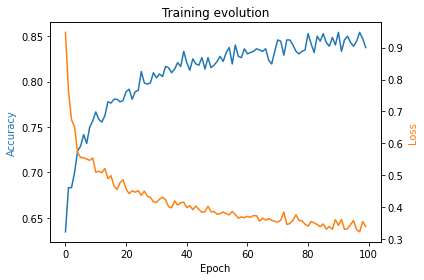

In [13]:
  plt.title('Training evolution')
  plt.xlabel('Epoch')

  color = 'tab:blue'
  plt.plot(history.history['accuracy'], color=color)
  plt.ylabel('Accuracy', color=color)

  plt.twinx()

  color = 'tab:orange'
  plt.plot(history.history['loss'], color=color)
  plt.ylabel('Loss', color=color)

  plt.tight_layout()
  plt.show()

## Test

In [14]:
# Creazione del dataset tensrflow di test 
test_target = test.pop(target_label)
test_dataset = (tf.data.Dataset.from_tensor_slices((test.values, test_target.values))).shuffle(len(test)).batch(1)

# Fase di test
test_loss, test_accuracy = model.evaluate(test_dataset)
print('\n\nTest Loss {}, Test Accuracy {}'.format(test_loss, test_accuracy))

90/90 [==============================] - 0s 902us/step - loss: 0.6395 - accuracy: 0.8111


Test Loss 0.63951575756073, Test Accuracy 0.8111110925674438


## Valutazione

In [15]:
# Creazione del dataset di valutazione
val_target = val.pop(target_label)
val_dataset = (tf.data.Dataset.from_tensor_slices(val.values)).batch(1)

# Fase di valutazione
predictions = model.predict(val_dataset)

sp, dp, st, dt = 0, 0, 0, 0

# Show some results
for prediction, survived in zip(predictions[:10], list(val_target[:10])):
  prediction = tf.sigmoid(prediction).numpy()

  print("Predicted survival: {:.2%}".format(prediction[0]),
       " | Actual outcome: ",
       ("SURVIVED" if bool(survived) else "DIED"))

Predicted survival: 45.07%  | Actual outcome:  SURVIVED
Predicted survival: 6.60%  | Actual outcome:  DIED
Predicted survival: 3.11%  | Actual outcome:  DIED
Predicted survival: 3.32%  | Actual outcome:  DIED
Predicted survival: 0.97%  | Actual outcome:  DIED
Predicted survival: 25.29%  | Actual outcome:  DIED
Predicted survival: 78.94%  | Actual outcome:  SURVIVED
Predicted survival: 46.90%  | Actual outcome:  DIED
Predicted survival: 10.68%  | Actual outcome:  DIED
Predicted survival: 4.74%  | Actual outcome:  DIED
